<a href="https://colab.research.google.com/github/zhar121/disseration-team-rep/blob/main/statistics_KL%2C_KS%2C_Z2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import pairwise_distances
from scipy.stats import entropy
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
!gdown 1GWqF6DLz6f9PR0mKg5h6kjbFBv2lHPFw

final_df = pd.read_csv('final_df.csv')

Downloading...
From: https://drive.google.com/uc?id=1GWqF6DLz6f9PR0mKg5h6kjbFBv2lHPFw
To: /content/final_df.csv
100% 15.2M/15.2M [00:00<00:00, 66.2MB/s]


Response time-based indicators (KL, KT, Z2)

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import entropy, zscore, kstest
from sklearn.preprocessing import MinMaxScaler

# Load the data
data5 = final_df.copy()

# Normalize response times using Min-Max Scaling
scaler = MinMaxScaler()
data5.loc[:, 'NormalizedResponseTime'] = scaler.fit_transform(data5[['ResponseTime']])

# Calculate Z-scores for response times
data5.loc[:, 'Z2'] = zscore(data5['NormalizedResponseTime'])

# Function to calculate KL divergence
def calculate_kl_divergence(p, q):
    p = np.array(p)
    q = np.array(q)

    # Add a small value to avoid log(0)
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon

    p = p / np.sum(p)
    q = q / np.sum(q)

    kl_divergence = np.sum(p * np.log(p / q))
    return kl_divergence

kl_divergence = []
ks_statistic = []

# Assume the normal response time distribution is the overall distribution
overall_response_time_dist = data5['NormalizedResponseTime'].values

# Iterate over each answerSheetId
for answerSheetId in data5['answerSheetId'].unique():
    answerSheet_data = data5[data5['answerSheetId'] == answerSheetId]
    answerSheet_data_response_time_dist = answerSheet_data['NormalizedResponseTime'].values

    # Ensure both distributions have the same length by sampling
    if len(answerSheet_data_response_time_dist) > len(overall_response_time_dist):
        answerSheet_data_response_time_dist = np.random.choice(answerSheet_data_response_time_dist, len(overall_response_time_dist), replace=False)
    elif len(answerSheet_data_response_time_dist) < len(overall_response_time_dist):
        overall_response_time_dist = np.random.choice(overall_response_time_dist, len(answerSheet_data_response_time_dist), replace=False)

    # Calculate KL divergence
    kl_div = calculate_kl_divergence(answerSheet_data_response_time_dist, overall_response_time_dist)
    kl_divergence.extend([kl_div] * len(answerSheet_data))

    # Calculate KS statistic
    ks_stat, _ = kstest(answerSheet_data_response_time_dist, overall_response_time_dist)
    ks_statistic.extend([ks_stat] * len(answerSheet_data))

data5.loc[:, 'KL'] = kl_divergence
data5.loc[:, 'KS'] = ks_statistic

In [4]:
data5 = data5.drop('NormalizedResponseTime', axis=1)

In [5]:
data5.columns

Index(['paperId', 'questionId', 'candidateId', 'answerSheetId', 'answer_score',
       'maxScore', 'answeredCorrectly', 'Difficulty', 'firstSeenAt',
       'lastAnsweredAt', 'ResponseTime', 'Expected response time',
       'SequenceOrder', 'TotalTestingTime', 'ExamScore', 'Z2', 'KL', 'KS'],
      dtype='object')

In [6]:
data5.shape


(60514, 18)

In [7]:
# Save data5 to csv
data5.to_csv('data5.csv', index=False)


# Visualisation of statistics and potential cheating answerSheets

In [8]:
# Set thresholds for anomaly detection
zscore_threshold = 2.0
kl_threshold = data5['KL'].mean() + 2 * data5['KL'].std()
ks_threshold = data5['KS'].mean() + 2 * data5['KS'].std()

# Identify potential cheaters
potential_cheaters = data5[(data5['Z2'].abs() > zscore_threshold) |
                          (data5['KL'] > kl_threshold) |
                          (data5['KS'] > ks_threshold)]

# Get unique cheater IDs
cheater_ids = potential_cheaters['answerSheetId'].unique()
num_cheaters = len(cheater_ids)

# Total number of candidates
total_candidates = data5['answerSheetId'].nunique()

# Cheaters percentage
cheaters_percentage = (num_cheaters / total_candidates) * 100

# Display results
print(f"Number of flagged candidates: {num_cheaters}")
print(f"Percentage of flagged candidates: {cheaters_percentage:.2f}%")

Number of flagged candidates: 692
Percentage of flagged candidates: 68.51%


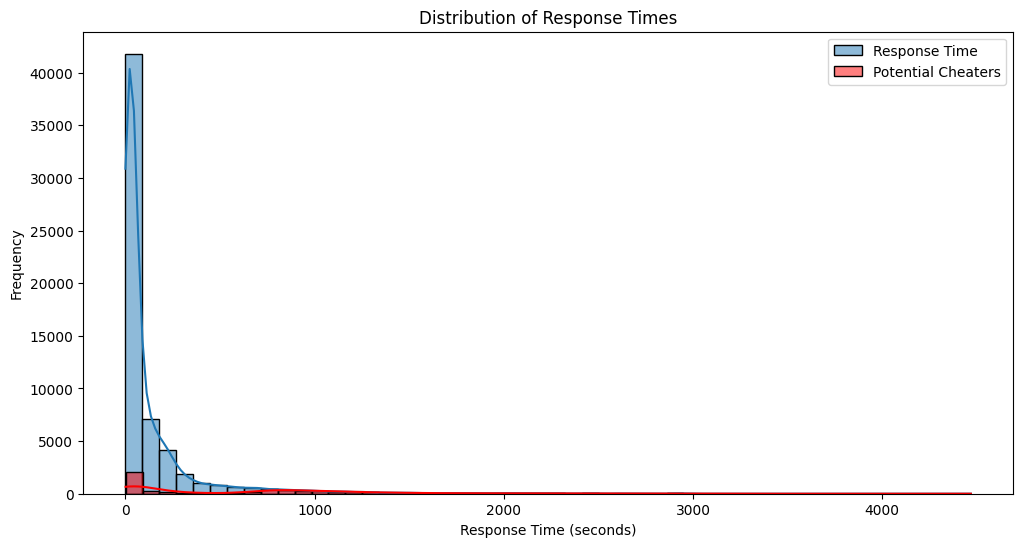

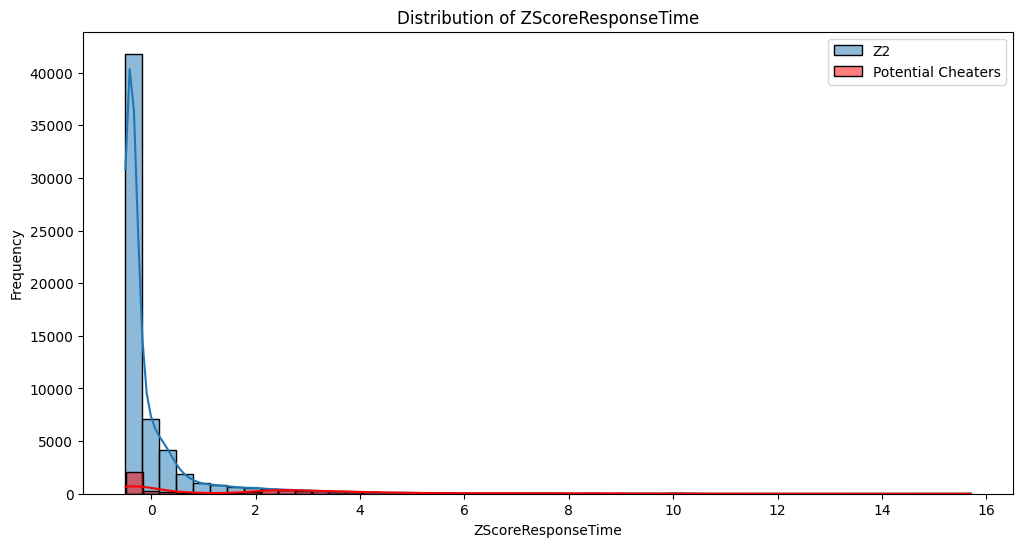

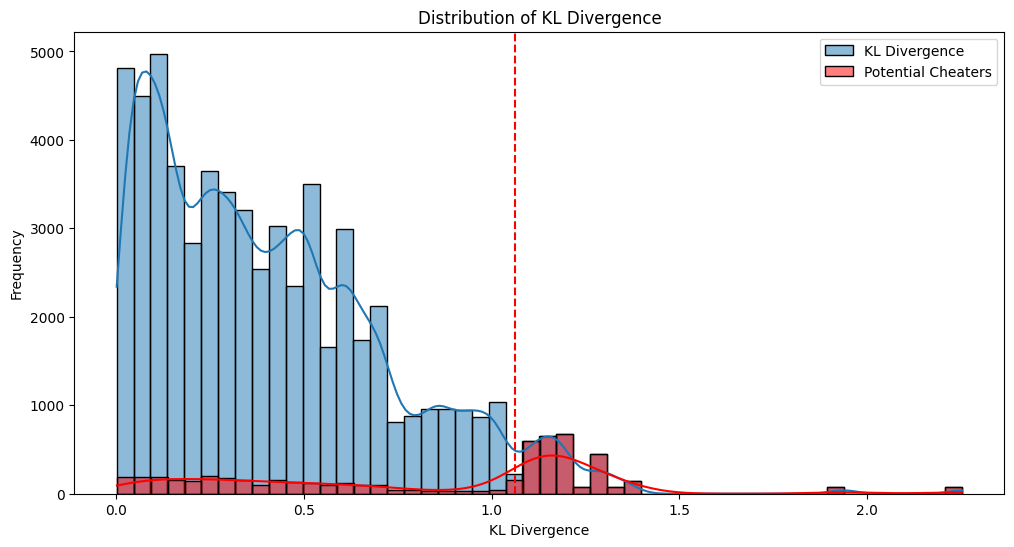

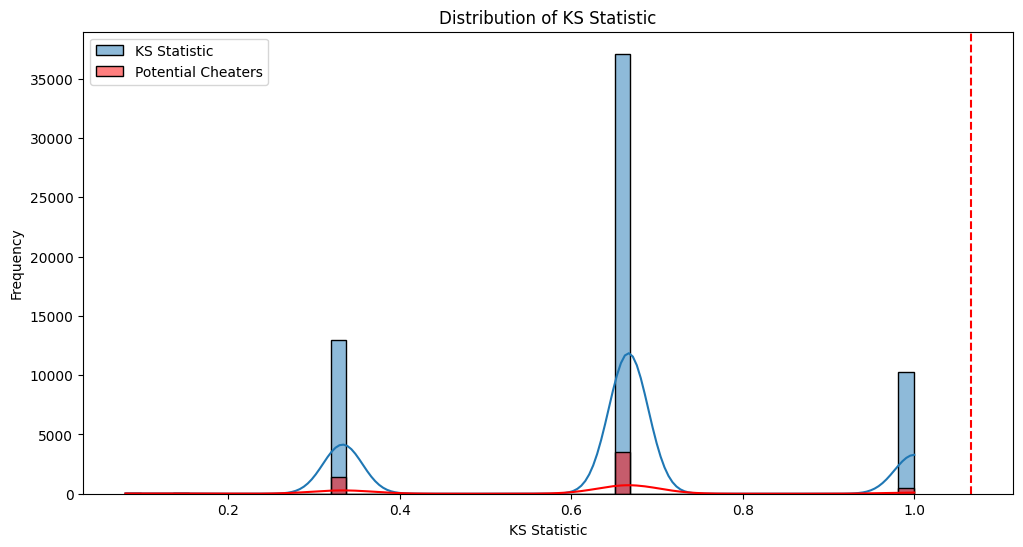

In [9]:
#Plot


# Plot the response times and anomalies for visualization
plt.figure(figsize=(12, 6))
sns.histplot(data5['ResponseTime'], bins=50, kde=True, label='Response Time')
sns.histplot(potential_cheaters['ResponseTime'], bins=50, color='red', kde=True, label='Potential Cheaters')
plt.title('Distribution of Response Times')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data5['Z2'], bins=50, kde=True, label='Z2')
sns.histplot(potential_cheaters['Z2'], bins=50, color='red', kde=True, label='Potential Cheaters')
plt.title('Distribution of ZScoreResponseTime')
plt.xlabel('ZScoreResponseTime')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data5['KL'], bins=50, kde=True, label='KL Divergence')
sns.histplot(potential_cheaters['KL'], bins=50, color='red', kde=True, label='Potential Cheaters')
plt.axvline(x=kl_threshold, color='r', linestyle='--')
plt.title('Distribution of KL Divergence')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data5['KS'], bins=50, kde=True, label='KS Statistic')
sns.histplot(potential_cheaters['KS'], bins=50, color='red', kde=True, label='Potential Cheaters')
plt.axvline(x=ks_threshold, color='r', linestyle='--')
plt.title('Distribution of KS Statistic')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.legend()
plt.show()